In [1]:
# imports
import gdstk
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon
import time

In [2]:
# load gds
lib = gdstk.read_gds(
    "C:/Users/USER/Documents/Phd/Test_Patterns-20260102T051200Z-3-001/Test_Patterns/pattern2_100_new.gds"
)

top_cell = lib.top_level()[0]
print("Top cell name:", top_cell.name)

Top cell name: TOP


In [3]:
# extract mask polygons
polygons = top_cell.get_polygons()
print("Number of polygons:", len(polygons))

MASK_LAYER = 1
MASK_DATATYPE = 0

mask_polys = []

for poly in polygons:
    if poly.layer == MASK_LAYER and poly.datatype == MASK_DATATYPE:
        mask_polys.append(poly)

print("Mask polygons found:", len(mask_polys))

Number of polygons: 3
Mask polygons found: 3


In [4]:
# rasterization
# define resolution
pixel_size_nm = 1.0            # 1 nm resolution
scale_factor = 1000.0          # µm → nm

# bounding box
bbox = top_cell.bounding_box()
min_x_um, min_y_um = bbox[0]
max_x_um, max_y_um = bbox[1]

width_um = max_x_um - min_x_um
height_um = max_y_um - min_y_um

# img size
img_width = int(np.ceil(round(width_um,5) * scale_factor))
img_height = int(np.ceil(round(height_um,5) * scale_factor))

print("Layout:", width_um, "µm ×", height_um, "µm")
print("Raster:", img_width, "×", img_height)

Layout: 0.7030000000000001 µm × 0.255 µm
Raster: 703 × 255


In [5]:
# blank canvas
raw_mask = np.zeros((img_height, img_width), dtype=np.float32)

print("Rasterizing", len(mask_polys), "polygons")

for poly in mask_polys:
    poly_shifted = (poly.points - [min_x_um, min_y_um]) * scale_factor

    rr, cc = polygon(
        poly_shifted[:, 1],
        poly_shifted[:, 0],
        shape=raw_mask.shape
    )

    raw_mask[rr, cc] = 1.0

Rasterizing 3 polygons


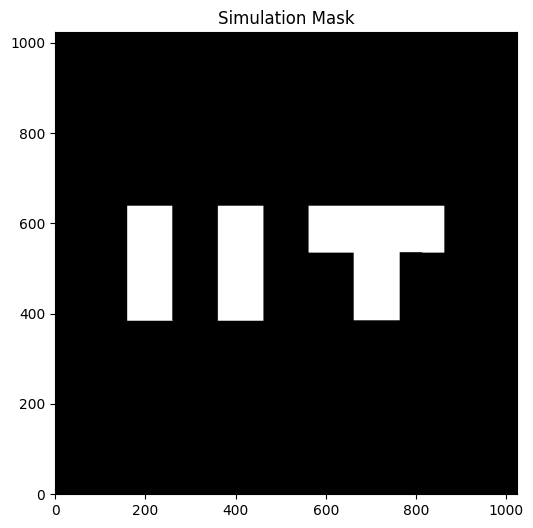

In [6]:
# Simulation window
N_sim = 1024

if img_width > N_sim or img_height > N_sim:
    print("WARNING: Enlarging simulation window")
    N_sim = 2048

# final simulation mask
mask = np.zeros((N_sim, N_sim), dtype=np.float32)

# offset to center the image
start_y = (N_sim - img_height) // 2
start_x = (N_sim - img_width) // 2

mask[
    start_y:start_y+img_height,
    start_x:start_x+img_width
] = raw_mask

plt.figure(figsize=(6, 6))
plt.imshow(mask, origin="lower", cmap="gray")
plt.title("Simulation Mask")
plt.savefig("C:/Users/USER/Documents/Phd/Code/Ouput/AmynILT/mask.png", dpi=300)
plt.show()

Calculating diffraction...
Simulation complete


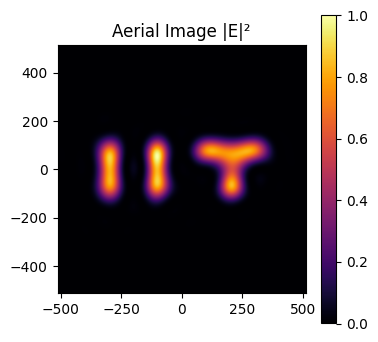

In [7]:
# Physical parameters

wavelength = 193.0      # nm
NA = 1.35
dx = pixel_size_nm

L_nm = N_sim * dx

#Grid Setup
x = np.linspace(-L_nm/2, L_nm/2, N_sim)
y = np.linspace(-L_nm/2, L_nm/2, N_sim)
X, Y = np.meshgrid(x, y)

# Frequency grid
fx = np.fft.fftfreq(N_sim, d=dx)
fy = np.fft.fftfreq(N_sim, d=dx)

FX, FY = np.meshgrid(fx, fy)
freq_radius = np.sqrt(FX**2 + FY**2)

# Cutoff frequency
f_cutoff = NA / wavelength

# Circular pupil
pupil = np.zeros_like(freq_radius)
pupil[freq_radius <= f_cutoff] = 1.0

# Forward diffraction
print("Calculating diffraction...")

mask_fft = np.fft.fft2(mask)
filtered_fft = mask_fft * pupil
field = np.fft.ifft2(filtered_fft)

# Aerial image
intensitya = np.abs(field)**2
intensitya /= intensitya.max()

print("Simulation complete")
plt.figure(figsize=(4, 4))
plt.imshow(intensitya, cmap="inferno",  extent=[-L_nm/2, L_nm/2, -L_nm/2, L_nm/2], origin='lower')
plt.title("Aerial Image |E|²")
plt.colorbar()
plt.show()

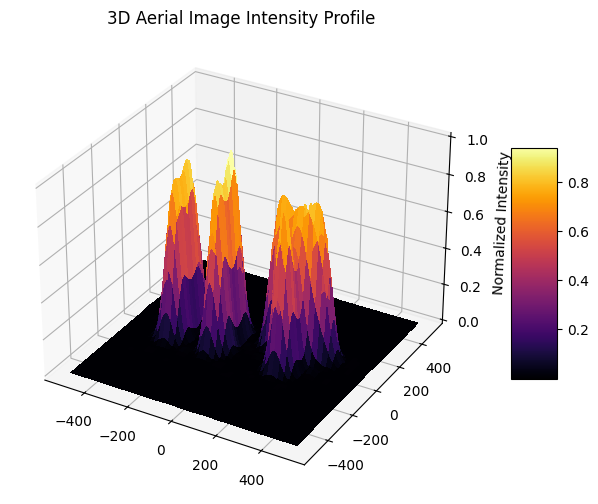

In [8]:
#3d aerial image
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(X, Y, intensitya, cmap="inferno", linewidth=0, antialiased=False)

ax.set_title("3D Aerial Image Intensity Profile")
ax.set_zlabel("Normalized Intensity")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [9]:
# Sigmoid resist model (Constant Threshold Resist)

def resist_sigmoid(intensity, threshold, a):
    """
    Continuous resist model used in ILT

    Parameters:
    1. intensity : 2D array
        Normalized aerial image |E|^2
    2. threshold : float
        Resist threshold (0–1)
    3. a : float
        Sigmoid steepness parameter

    Returns:
    resist : 2D array
        Continuous resist image
    """

    resist = 1.0 / (1.0 + np.exp(-a * (intensity - threshold)))
    return resist

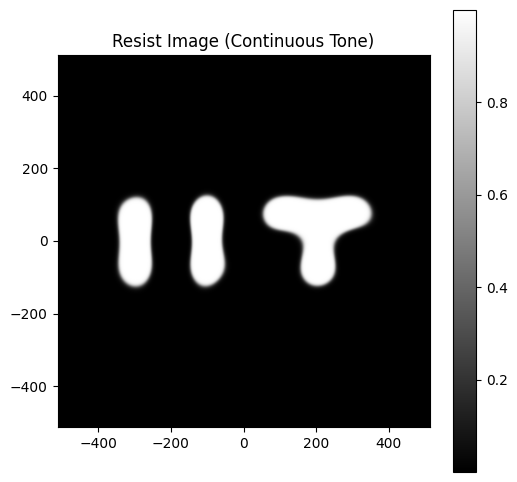

In [10]:
# Apply resist model
threshold = 0.25      # typical value
a_sigmoid = 30       # resist contrast

resist_image = resist_sigmoid(
    intensitya,
    threshold=threshold,
    a=a_sigmoid
)

plt.figure(figsize=(6,6))
plt.imshow(resist_image, cmap="gray", origin="lower", extent=[-L_nm/2, L_nm/2, -L_nm/2, L_nm/2])
plt.title("Resist Image (Continuous Tone)")
plt.colorbar()
plt.show()

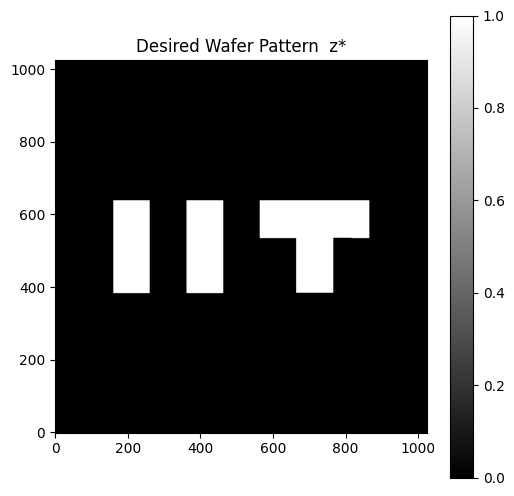

In [11]:
# Desired wafer pattern z*

z_target = mask.copy()   # usually same as layout

plt.figure(figsize=(6,6))
plt.imshow(z_target, origin="lower", cmap="gray")
plt.title("Desired Wafer Pattern  z*")
plt.colorbar()
plt.show()


In [12]:
# Cost function

def cost_function(z, z_target):
    """
    L2 wafer error
    """
    return np.sum((z - z_target)**2)


In [13]:
# STEP 1 cost: aerial image fidelity only
# Eq. (27)

def aerial_cost(mask, pupil, z_target):
    """
    J1(m) = || z* - |H m|^2 ||^2
    """

    field = np.fft.ifft2(np.fft.fft2(mask) * pupil)
    aerial = np.abs(field)**2
    #aerial /= aerial.max()

    return np.sum((z_target - aerial)**2)


In [14]:
# Sigmoid derivative

def sigmoid_derivative(z, a):
    """
    σ'(I) = a z (1 - z)
    """
    return a * z * (1.0 - z)


In [15]:
# Adjoint optical operator

def adjoint_operator(x, pupil):
    """
    H† x
    """
    X = np.fft.fft2(x)
    Y = X * pupil
    return np.fft.ifft2(Y)


In [16]:
# Analytical ILT gradient

def ilt_gradient(mask, pupil, z_target, threshold, a):
    """
    Analytical gradient of ILT cost function
    """

    # Forward optics
    mask_fft = np.fft.fft2(mask)
    field = np.fft.ifft2(mask_fft * pupil)

    intensity = np.abs(field)**2
    intensity /= intensity.max()

    # Resist
    z = resist_sigmoid(intensity, threshold, a)

    # Error term
    error = z - z_target

    # Sigmoid derivative
    dz_dI = sigmoid_derivative(z, a)

    # Chain rule term
    temp = error * dz_dI * field

    # Adjoint propagation
    grad = 2 * np.real(adjoint_operator(temp, pupil))

    return grad


In [17]:
# STEP 1 gradient (Eq. 28)

def aerial_gradient(mask, pupil, z_target):
    """
    ∇R_aerial(m)
    """

    field = np.fft.ifft2(np.fft.fft2(mask) * pupil)
    aerial = np.abs(field)**2
    #aerial /= aerial.max()

    error = z_target - aerial

    temp = error * field

    grad = -2 * np.real(
        np.fft.ifft2(np.fft.fft2(temp) * pupil)
    )

    return grad


In [18]:
# STEP 1 OPTIMIZATION

total_start_time = time.perf_counter()
step1_start = time.perf_counter()

step1_iters = 80
step1_stepsize = 0.06

m = z_target.copy()   # initialization exactly as paper

step1_cost = []

for itr in range(step1_iters):

    grad = aerial_gradient(m, pupil, z_target)

    m = m - step1_stepsize * grad

    # clip only for stability
    m = np.clip(m, 0.0, 1.0)

    cost = aerial_cost(m, pupil, z_target)
    step1_cost.append(cost)

    if itr % 5 == 0:
        print(f"[STEP 1] Iter {itr:03d} | Cost = {cost:.6e}")

step1_end = time.perf_counter()
step1_time = step1_end - step1_start
print(f"\nStep-1 Time: {step1_time:.4f} seconds")

[STEP 1] Iter 000 | Cost = 1.880086e+04
[STEP 1] Iter 005 | Cost = 1.786287e+04
[STEP 1] Iter 010 | Cost = 1.712583e+04
[STEP 1] Iter 015 | Cost = 1.651562e+04
[STEP 1] Iter 020 | Cost = 1.600847e+04
[STEP 1] Iter 025 | Cost = 1.558936e+04
[STEP 1] Iter 030 | Cost = 1.524558e+04
[STEP 1] Iter 035 | Cost = 1.496558e+04
[STEP 1] Iter 040 | Cost = 1.473890e+04
[STEP 1] Iter 045 | Cost = 1.455622e+04
[STEP 1] Iter 050 | Cost = 1.440945e+04
[STEP 1] Iter 055 | Cost = 1.429168e+04
[STEP 1] Iter 060 | Cost = 1.419716e+04
[STEP 1] Iter 065 | Cost = 1.412116e+04
[STEP 1] Iter 070 | Cost = 1.405980e+04
[STEP 1] Iter 075 | Cost = 1.401000e+04

Step-1 Time: 26.0683 seconds


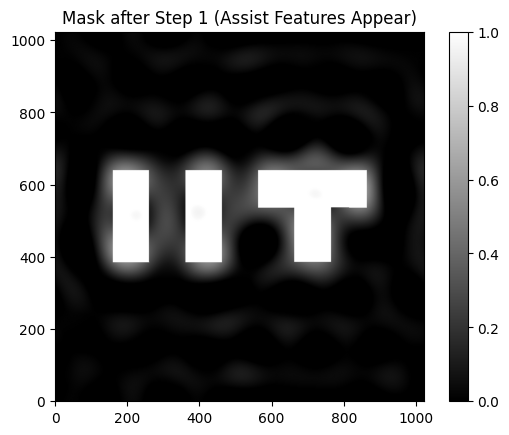

In [19]:
mask_step1 = m.copy()

plt.imshow(mask_step1, cmap="gray", origin="lower")
plt.title("Mask after Step 1 (Assist Features Appear)")
plt.colorbar()
plt.savefig("C:/Users/USER/Documents/Phd/Code/Ouput/AmynILT/maskstep1.png", dpi=300)
plt.show()


In [20]:
# Parametric mask mapping
# Eq. (19)

def h_to_mask(h):
    return 0.5 * (1.0 + np.cos(h))


def dh_dm(h):
    return -0.5 * np.sin(h)


In [21]:
# Initialization

h = np.arccos(2.0 * mask_step1 - 1.0)


In [22]:
# Gradient in h-domain

def ilt_gradient_h(h, pupil, z_target, threshold, a):
    
    m = h_to_mask(h)

    grad_m = ilt_gradient(
        m,
        pupil,
        z_target,
        threshold,
        a
    )

    grad_h = grad_m * dh_dm(h)
    return grad_h


In [23]:
# Steepest descent step

def gradient_descent_step(h, grad_h, step_size):
    return h - step_size * grad_h


In [24]:
# ILT optimization loop

step2_start = time.perf_counter()

num_iters = 100
step_size = 10

cost_history = []

for itr in range(num_iters):

    # Current mask
    m = h_to_mask(h)

    # Forward simulation
    mask_fft = np.fft.fft2(m)
    field = np.fft.ifft2(mask_fft * pupil)

    intensity = np.abs(field)**2
    intensity /= intensity.max()

    z = resist_sigmoid(intensity, threshold, a_sigmoid)

    # Cost
    cost = cost_function(z, z_target)
    cost_history.append(cost)

    # Gradient
    grad_h = ilt_gradient_h(
        h,
        pupil,
        z_target,
        threshold,
        a_sigmoid
    )

    # Update
    h = gradient_descent_step(h, grad_h, step_size)

    if itr % 2 == 0:
        print(f"Iteration {itr:03d} | Cost = {cost:.6e}")
h_step2 = h.copy()

step2_end = time.perf_counter()
step2_time = step2_end - step2_start
print(f"\nStep-2 Time: {step2_time:.4f} seconds")

Iteration 000 | Cost = 9.504167e+03
Iteration 002 | Cost = 8.506069e+03
Iteration 004 | Cost = 1.024510e+04
Iteration 006 | Cost = 1.098237e+04
Iteration 008 | Cost = 8.375392e+03
Iteration 010 | Cost = 6.144079e+03
Iteration 012 | Cost = 6.756963e+03
Iteration 014 | Cost = 6.031385e+03
Iteration 016 | Cost = 5.690295e+03
Iteration 018 | Cost = 5.460443e+03
Iteration 020 | Cost = 5.112838e+03
Iteration 022 | Cost = 4.744714e+03
Iteration 024 | Cost = 4.907164e+03
Iteration 026 | Cost = 5.141173e+03
Iteration 028 | Cost = 4.937707e+03
Iteration 030 | Cost = 4.739608e+03
Iteration 032 | Cost = 4.355637e+03
Iteration 034 | Cost = 4.490740e+03
Iteration 036 | Cost = 4.363331e+03
Iteration 038 | Cost = 4.926762e+03
Iteration 040 | Cost = 4.689950e+03
Iteration 042 | Cost = 4.371014e+03
Iteration 044 | Cost = 4.407223e+03
Iteration 046 | Cost = 4.071987e+03
Iteration 048 | Cost = 4.268131e+03
Iteration 050 | Cost = 4.125313e+03
Iteration 052 | Cost = 4.132447e+03
Iteration 054 | Cost = 4.040

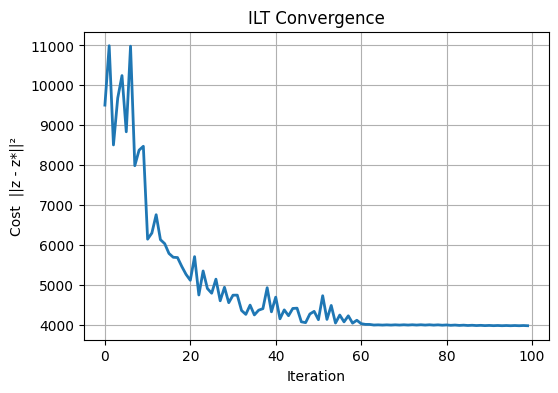

In [25]:
# Cost convergence

plt.figure(figsize=(6,4))
plt.plot(cost_history, linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Cost  ||z - z*||²")
plt.title("ILT Convergence")
plt.grid(True)
plt.show()

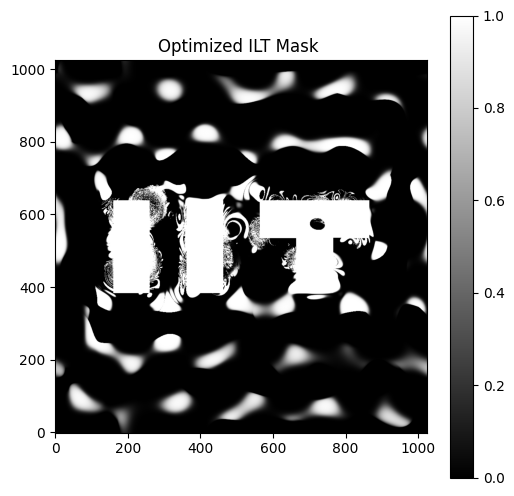

In [26]:
final_mask = h_to_mask(h)

plt.figure(figsize=(6,6))
plt.imshow(final_mask, cmap="gray", origin="lower")
plt.title("Optimized ILT Mask ")
plt.colorbar()
plt.savefig("C:/Users/USER/Documents/Phd/Code/Ouput/AmynILT/maskstep2.png", dpi=300)

plt.show()


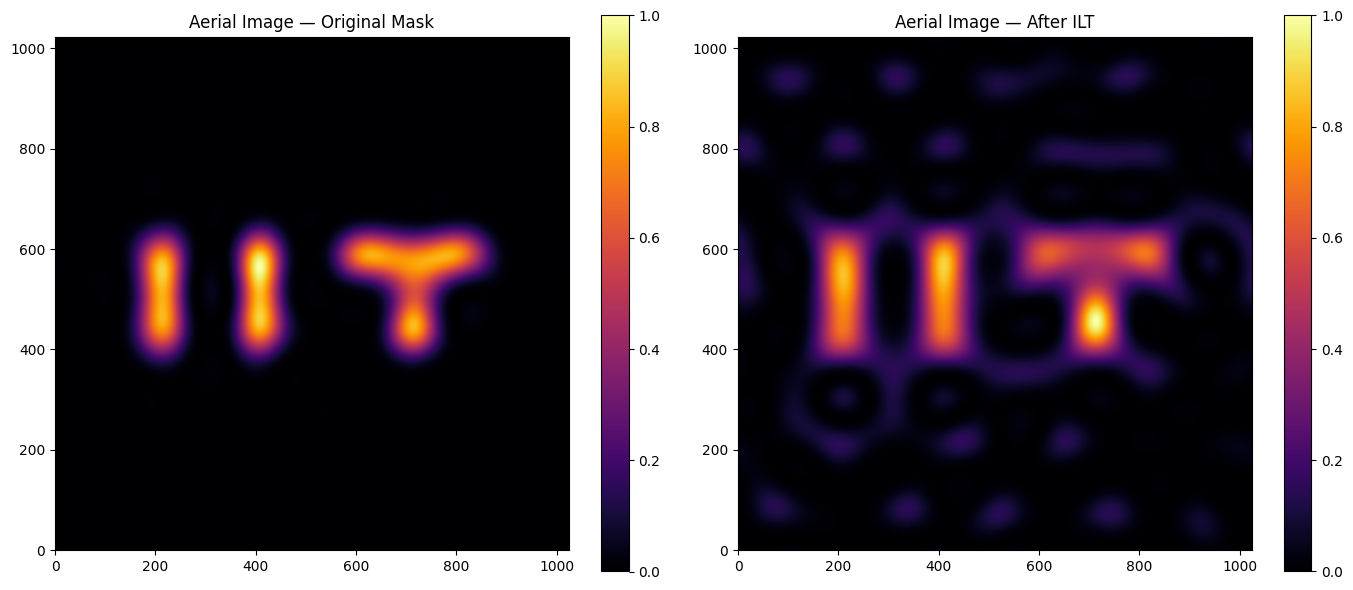

In [27]:
# Aerial image BEFORE ILT

field_orig = np.fft.ifft2(np.fft.fft2(mask) * pupil)
aerial_orig = np.abs(field_orig)**2
aerial_orig /= aerial_orig.max()

# Aerial image AFTER ILT

field_ilt = np.fft.ifft2(np.fft.fft2(final_mask) * pupil)
aerial_ilt = np.abs(field_ilt)**2
aerial_ilt /= aerial_ilt.max()

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(aerial_orig, cmap="inferno", origin="lower")
plt.title("Aerial Image — Original Mask")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(aerial_ilt, cmap="inferno", origin="lower")
plt.title("Aerial Image — After ILT")
plt.colorbar()

plt.tight_layout()
plt.show()


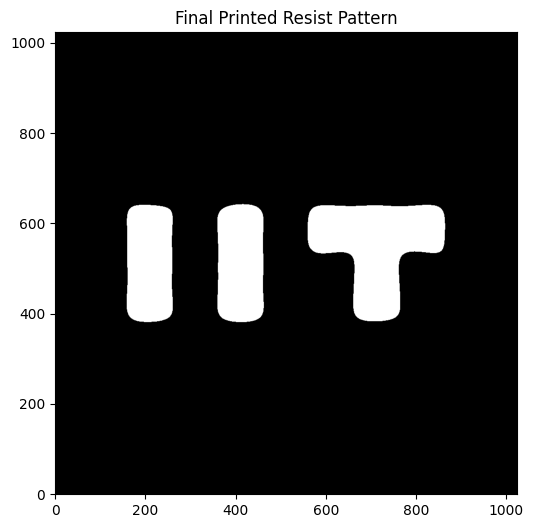

In [28]:
# continuous resist
z = resist_sigmoid(aerial_ilt, threshold=threshold, a=a_sigmoid)

# binary resist
binary_resist = np.zeros_like(z)
binary_resist[z >= 0.5] = 1.0

plt.figure(figsize=(6,6))
plt.imshow(binary_resist, cmap="gray", origin="lower")
plt.title("Final Printed Resist Pattern")
plt.show()


In [29]:
# Enhancement 1 - Aerial image penalty 3.2.3

def aerial_penalty(mask, pupil, z_target):

    field = np.fft.ifft2(np.fft.fft2(mask) * pupil)
    aerial = np.abs(field)**2

    return np.sum((z_target - aerial)**2)
def aerial_penalty_gradient(mask, pupil, z_target):

    field = np.fft.ifft2(np.fft.fft2(mask) * pupil)
    aerial = np.abs(field)**2

    error = z_target - aerial

    temp = error * np.conj(field)

    grad = -2 * np.real(
        np.fft.ifft2(np.fft.fft2(temp) * pupil)
    )

    return grad


In [30]:
# Enchancement 2 - Discretization penalty 3.2.1
def discretization_penalty(mask):
    return np.sum(4 * mask * (1 - mask))
def discretization_gradient(mask):
    return 4 * (1 - 2 * mask)


In [31]:
# Encahncement 3 - Complexity (TV) penalty 3.2.2
def tv_gradient(mask):

    dx = np.roll(mask, -1, axis=1) - mask
    dy = np.roll(mask, -1, axis=0) - mask

    grad = (
        dx - np.roll(dx, 1, axis=1)
        + dy - np.roll(dy, 1, axis=0)
    )

    return grad


In [32]:
phase2_start = time.perf_counter()

print("\n--- Phase 2: Contour + Aerial ---")

cfid = 1.0
caerial = 0.25
cdis = 0.0
cTV = 0.0

step = 5.0
iters = 100

for itr in range(iters):

    m = h_to_mask(h)

    # forward model
    field = np.fft.ifft2(np.fft.fft2(m) * pupil)
    intensity = np.abs(field)**2
    z = resist_sigmoid(intensity, threshold, a_sigmoid)

    # ---- costs ----
    F = np.sum((z - z_target)**2)
    Ra = aerial_penalty(m, pupil, z_target)

    total_cost = cfid * F + caerial * Ra

    # ---- gradients ----
    grad = (
        cfid * ilt_gradient(m, pupil, z_target, threshold, a_sigmoid)
        + caerial * aerial_penalty_gradient(m, pupil, z_target)
    )

    # chain rule
    grad_h = grad * dh_dm(h)

    h -= step * grad_h

    if itr % 5 == 0:
        print(
            f"[PH2] Iter {itr:03d} | "
            f"F = {F:.4e} | "
            f"Ra = {Ra:.4e} | "
            f"Total = {total_cost:.4e}"
        )

phase2_end = time.perf_counter()
phase2_time = phase2_end - phase2_start
print(f"\nPhase-2 Time: {phase2_time:.4f} seconds")


--- Phase 2: Contour + Aerial ---
[PH2] Iter 000 | F = 3.3712e+04 | Ra = 2.0899e+04 | Total = 3.8937e+04
[PH2] Iter 005 | F = 2.7150e+04 | Ra = 1.9248e+04 | Total = 3.1962e+04
[PH2] Iter 010 | F = 2.4919e+04 | Ra = 1.8449e+04 | Total = 2.9531e+04
[PH2] Iter 015 | F = 2.3564e+04 | Ra = 1.7961e+04 | Total = 2.8055e+04
[PH2] Iter 020 | F = 2.2633e+04 | Ra = 1.7649e+04 | Total = 2.7045e+04
[PH2] Iter 025 | F = 2.1970e+04 | Ra = 1.7443e+04 | Total = 2.6331e+04
[PH2] Iter 030 | F = 2.1482e+04 | Ra = 1.7302e+04 | Total = 2.5807e+04
[PH2] Iter 035 | F = 2.1107e+04 | Ra = 1.7201e+04 | Total = 2.5407e+04
[PH2] Iter 040 | F = 2.0808e+04 | Ra = 1.7128e+04 | Total = 2.5090e+04
[PH2] Iter 045 | F = 2.0562e+04 | Ra = 1.7073e+04 | Total = 2.4831e+04
[PH2] Iter 050 | F = 2.0354e+04 | Ra = 1.7031e+04 | Total = 2.4612e+04
[PH2] Iter 055 | F = 2.0173e+04 | Ra = 1.6998e+04 | Total = 2.4422e+04
[PH2] Iter 060 | F = 2.0011e+04 | Ra = 1.6973e+04 | Total = 2.4254e+04
[PH2] Iter 065 | F = 1.9862e+04 | Ra = 1.6

In [33]:
phase3_start = time.perf_counter()

print("\n--- Phase 3: + Discretization ---")

cdis = 0.005
step = 3.0
iters = 80

for itr in range(iters):

    m = h_to_mask(h)

    field = np.fft.ifft2(np.fft.fft2(m) * pupil)
    intensity = np.abs(field)**2
    z = resist_sigmoid(intensity, threshold, a_sigmoid)

    F = np.sum((z - z_target)**2)
    Ra = aerial_penalty(m, pupil, z_target)
    Rd = discretization_penalty(m)

    total_cost = cfid * F + caerial * Ra + cdis * Rd

    grad = (
        cfid * ilt_gradient(m, pupil, z_target, threshold, a_sigmoid)
        + caerial * aerial_penalty_gradient(m, pupil, z_target)
        + cdis * discretization_gradient(m)
    )

    grad_h = grad * dh_dm(h)
    h -= step * grad_h

    if itr % 5 == 0:
        print(
            f"[PH3] Iter {itr:03d} | "
            f"F = {F:.4e} | "
            f"Ra = {Ra:.4e} | "
            f"Rd = {Rd:.4e} | "
            f"Total = {total_cost:.4e}"
        )


phase3_end = time.perf_counter()
phase3_time = phase3_end - phase3_start
print(f"\nPhase-3 Time: {phase3_time:.4f} seconds")


--- Phase 3: + Discretization ---
[PH3] Iter 000 | F = 1.8985e+04 | Ra = 1.6872e+04 | Rd = 1.0045e+05 | Total = 2.3705e+04
[PH3] Iter 005 | F = 1.8898e+04 | Ra = 1.6876e+04 | Rd = 9.1547e+04 | Total = 2.3575e+04
[PH3] Iter 010 | F = 1.8872e+04 | Ra = 1.6885e+04 | Rd = 8.3215e+04 | Total = 2.3509e+04
[PH3] Iter 015 | F = 1.8866e+04 | Ra = 1.6893e+04 | Rd = 7.5392e+04 | Total = 2.3467e+04
[PH3] Iter 020 | F = 1.8867e+04 | Ra = 1.6902e+04 | Rd = 6.8069e+04 | Total = 2.3433e+04
[PH3] Iter 025 | F = 1.8868e+04 | Ra = 1.6909e+04 | Rd = 6.1245e+04 | Total = 2.3402e+04
[PH3] Iter 030 | F = 1.8868e+04 | Ra = 1.6914e+04 | Rd = 5.4919e+04 | Total = 2.3371e+04
[PH3] Iter 035 | F = 1.8866e+04 | Ra = 1.6919e+04 | Rd = 4.9087e+04 | Total = 2.3341e+04
[PH3] Iter 040 | F = 1.8863e+04 | Ra = 1.6923e+04 | Rd = 4.3739e+04 | Total = 2.3313e+04
[PH3] Iter 045 | F = 1.8860e+04 | Ra = 1.6927e+04 | Rd = 3.8858e+04 | Total = 2.3286e+04
[PH3] Iter 050 | F = 1.8857e+04 | Ra = 1.6929e+04 | Rd = 3.4427e+04 | Total

In [34]:
phase4_start = time.perf_counter()

print("\n--- Phase 4: + TV ---")

cTV = 0.005
step = 1.5
iters = 80

for itr in range(iters):

    m = h_to_mask(h)

    field = np.fft.ifft2(np.fft.fft2(m) * pupil)
    intensity = np.abs(field)**2
    z = resist_sigmoid(intensity, threshold, a_sigmoid)

    F  = np.sum((z - z_target)**2)
    Ra = aerial_penalty(m, pupil, z_target)
    Rd = discretization_penalty(m)
    Rt = np.sum(np.abs(tv_gradient(m)))

    total_cost = cfid * F + caerial * Ra + cdis * Rd + cTV * Rt

    grad = (
        cfid * ilt_gradient(m, pupil, z_target, threshold, a_sigmoid)
        + caerial * aerial_penalty_gradient(m, pupil, z_target)
        + cdis * discretization_gradient(m)
        + cTV * tv_gradient(m)
    )

    grad_h = grad * dh_dm(h)
    h -= step * grad_h

    if itr % 5 == 0:
        print(
            f"[PH4] Iter {itr:03d} | "
            f"F = {F:.4e} | "
            f"Ra = {Ra:.4e} | "
            f"Rd = {Rd:.4e} | "
            f"TV = {Rt:.4e} | "
            f"Total = {total_cost:.4e}"
        )

phase4_end = time.perf_counter()
phase4_time = phase4_end - phase4_start
print(f"\nPhase-4 Time: {phase4_time:.4f} seconds")


--- Phase 4: + TV ---
[PH4] Iter 000 | F = 1.8842e+04 | Ra = 1.6937e+04 | Rd = 1.5905e+04 | TV = 5.5554e+04 | Total = 2.3433e+04
[PH4] Iter 005 | F = 1.8842e+04 | Ra = 1.6937e+04 | Rd = 1.4779e+04 | TV = 5.6034e+04 | Total = 2.3431e+04
[PH4] Iter 010 | F = 1.8842e+04 | Ra = 1.6938e+04 | Rd = 1.3718e+04 | TV = 5.6507e+04 | Total = 2.3428e+04
[PH4] Iter 015 | F = 1.8842e+04 | Ra = 1.6938e+04 | Rd = 1.2719e+04 | TV = 5.6972e+04 | Total = 2.3425e+04
[PH4] Iter 020 | F = 1.8842e+04 | Ra = 1.6938e+04 | Rd = 1.1780e+04 | TV = 5.7428e+04 | Total = 2.3423e+04
[PH4] Iter 025 | F = 1.8842e+04 | Ra = 1.6938e+04 | Rd = 1.0897e+04 | TV = 5.7875e+04 | Total = 2.3421e+04
[PH4] Iter 030 | F = 1.8842e+04 | Ra = 1.6939e+04 | Rd = 1.0068e+04 | TV = 5.8310e+04 | Total = 2.3418e+04
[PH4] Iter 035 | F = 1.8842e+04 | Ra = 1.6939e+04 | Rd = 9.2905e+03 | TV = 5.8735e+04 | Total = 2.3417e+04
[PH4] Iter 040 | F = 1.8841e+04 | Ra = 1.6939e+04 | Rd = 8.5625e+03 | TV = 5.9147e+04 | Total = 2.3415e+04
[PH4] Iter 045

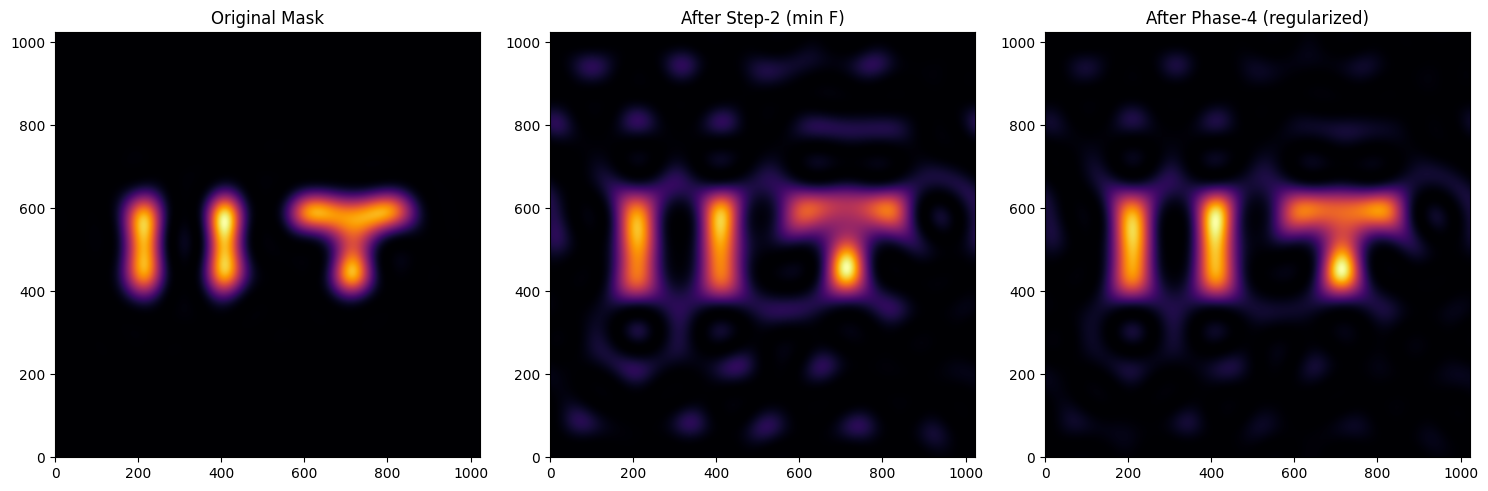

In [35]:
mask_orig   = mask.copy()
mask_step2  = h_to_mask(h_step2)   # save h before phase-3
mask_final  = h_to_mask(h)         # after phase-4


def aerial_from_mask(m):
    field = np.fft.ifft2(np.fft.fft2(m) * pupil)
    I = np.abs(field)**2
    return I / I.max()


I_orig  = aerial_from_mask(mask_orig)
I_s2    = aerial_from_mask(mask_step2)
I_final = aerial_from_mask(mask_final)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(I_orig, cmap="inferno", origin='lower')
plt.title("Original Mask")

plt.subplot(1,3,2)
plt.imshow(I_s2, cmap="inferno", origin='lower')
plt.title("After Step-2 (min F)")

plt.subplot(1,3,3)
plt.imshow(I_final, cmap="inferno", origin='lower')
plt.title("After Phase-4 (regularized)")

plt.tight_layout()
plt.savefig("C:/Users/USER/Documents/Phd/Code/Ouput/AmynILT/aerial.png", dpi=300)

plt.show()


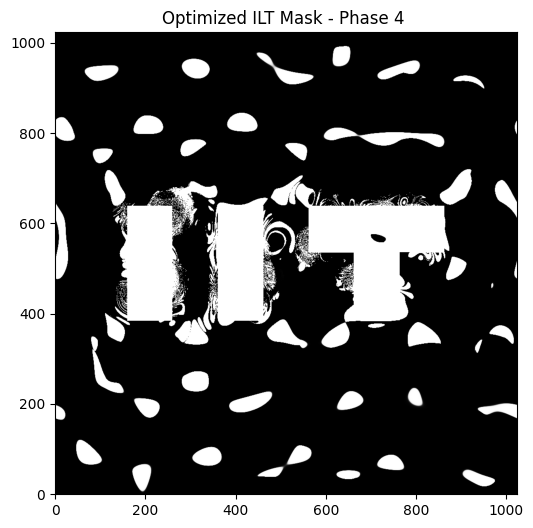

In [36]:
mask_final = h_to_mask(h)

plt.figure(figsize=(6,6))
plt.imshow(mask_final, cmap="gray", origin="lower")
plt.title("Optimized ILT Mask - Phase 4 ")
plt.savefig("C:/Users/USER/Documents/Phd/Code/Ouput/AmynILT/maskphase4.png", dpi=300)

plt.show()


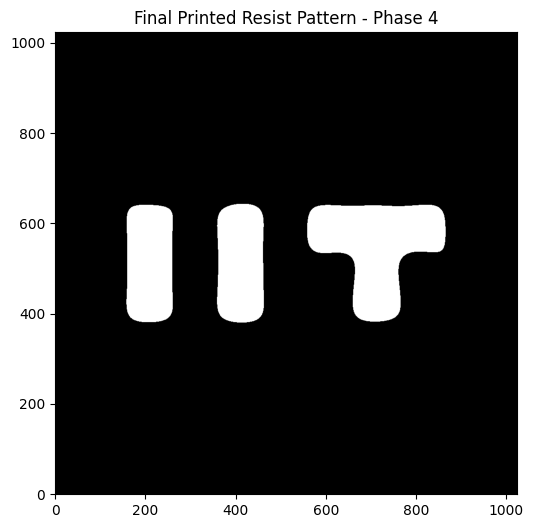

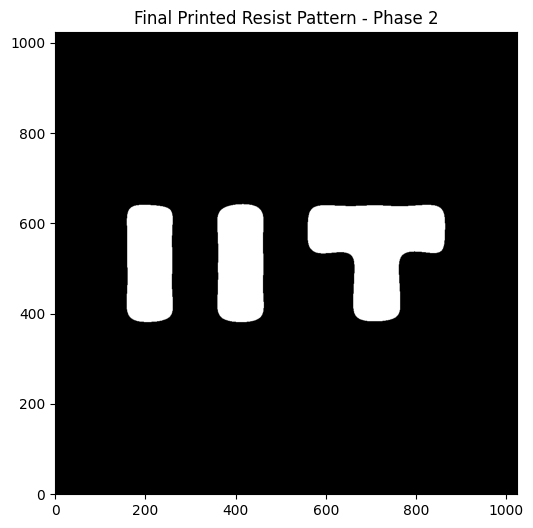

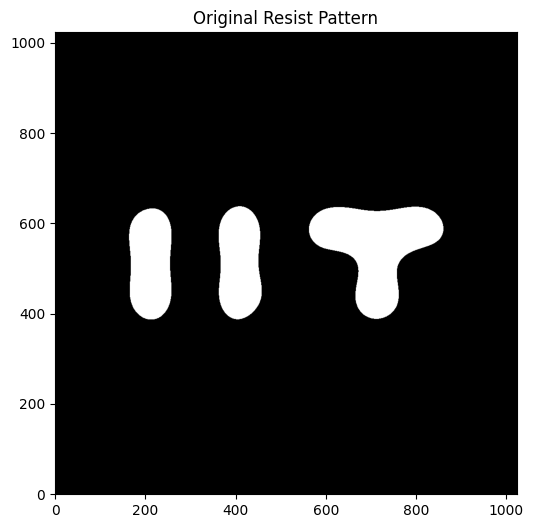

In [37]:
# continuous resist
z = resist_sigmoid(I_final, threshold=threshold, a=a_sigmoid)

# binary resist
binary_resist = np.zeros_like(z)
binary_resist[z >= 0.5] = 1.0

plt.figure(figsize=(6,6))
plt.imshow(binary_resist, cmap="gray", origin="lower")
plt.title("Final Printed Resist Pattern - Phase 4")
plt.savefig("C:/Users/USER/Documents/Phd/Code/Ouput/AmynILT/resist.png", dpi=300)

plt.show()

z = resist_sigmoid(I_s2, threshold=threshold, a=a_sigmoid)

# binary resist
binary_resist = np.zeros_like(z)
binary_resist[z >= 0.5] = 1.0

plt.figure(figsize=(6,6))
plt.imshow(binary_resist, cmap="gray", origin="lower")
plt.title("Final Printed Resist Pattern - Phase 2")
plt.savefig("C:/Users/USER/Documents/Phd/Code/Ouput/AmynILT/resistphase2.png", dpi=300)

plt.show()

z = resist_sigmoid(I_orig, threshold=threshold, a=a_sigmoid)

# binary resist
binary_resist = np.zeros_like(z)
binary_resist[z >= 0.5] = 1.0

plt.figure(figsize=(6,6))
plt.imshow(binary_resist, cmap="gray", origin="lower")
plt.title("Original Resist Pattern")
plt.savefig("C:/Users/USER/Documents/Phd/Code/Ouput/AmynILT/resistphase4.png", dpi=300)

plt.show()

In [38]:
total_end_time = time.perf_counter()
total_time = total_end_time - total_start_time

print("\n==============================")
print("CPU EXECUTION TIME SUMMARY")
print("==============================")
print(f"Step-1   : {step1_time:.4f} sec")
print(f"Step-2   : {step2_time:.4f} sec")
print(f"Phase-2  : {phase2_time:.4f} sec")
print(f"Phase-3  : {phase3_time:.4f} sec")
print(f"Phase-4  : {phase4_time:.4f} sec")
print("------------------------------")
print(f"TOTAL    : {total_time:.4f} sec")


CPU EXECUTION TIME SUMMARY
Step-1   : 26.0683 sec
Step-2   : 38.9375 sec
Phase-2  : 68.3664 sec
Phase-3  : 56.0828 sec
Phase-4  : 60.6876 sec
------------------------------
TOTAL    : 258.2559 sec


In [39]:
def contrast(I):
    return (I.max() - I.min()) / (I.max() + I.min())

print("Contrast:")
print("Original :", contrast(I_orig))
print("Step-2   :", contrast(I_s2))
print("Phase-4  :", contrast(I_final))


Contrast:
Original : 0.9999999999999711
Step-2   : 0.9999999999999921
Phase-4  : 0.9999999999999543


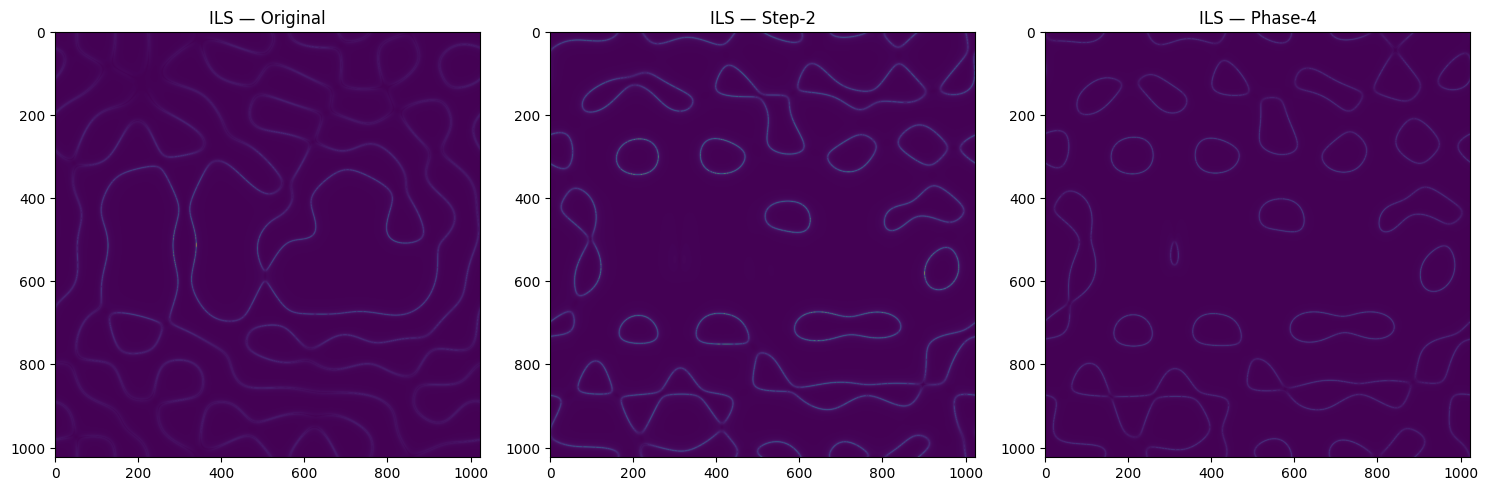

In [40]:
def ils(I, eps=1e-6):
    gx, gy = np.gradient(I)
    grad = np.sqrt(gx**2 + gy**2)
    return grad / (I + eps)

ILS_orig  = ils(I_orig)
ILS_s2    = ils(I_s2)
ILS_final = ils(I_final)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(ILS_orig, cmap="viridis")
plt.title("ILS — Original")

plt.subplot(1,3,2)
plt.imshow(ILS_s2, cmap="viridis")
plt.title("ILS — Step-2")

plt.subplot(1,3,3)
plt.imshow(ILS_final, cmap="viridis")
plt.title("ILS — Phase-4")

plt.tight_layout()
plt.show()


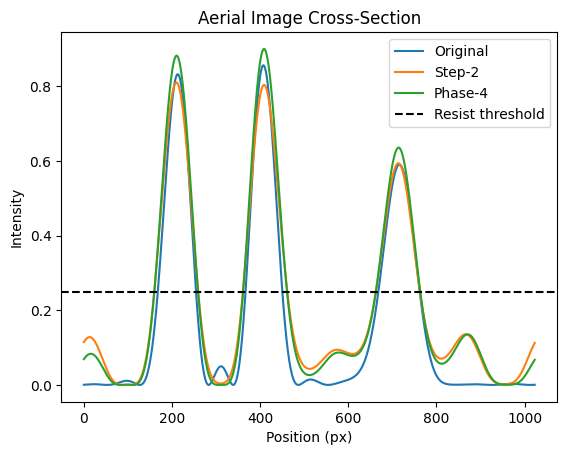

In [41]:
row = N_sim // 2

plt.plot(I_orig[row],  label="Original")
plt.plot(I_s2[row],    label="Step-2")
plt.plot(I_final[row], label="Phase-4")

plt.axhline(threshold, color="k", linestyle="--", label="Resist threshold")

plt.legend()
plt.title("Aerial Image Cross-Section")
plt.xlabel("Position (px)")
plt.ylabel("Intensity")
plt.show()


# GPU

In [42]:
import os
os.environ["CUDA_PATH"] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.9"
import cupy as cp

In [43]:
# CuPy import
import cupy as cp
from cupy.fft import fft2 as cfft2, ifft2 as cifft2

print("CuPy version:", cp.__version__)
print("GPU device:", cp.cuda.runtime.getDeviceProperties(0)['name'].decode())

CuPy version: 13.6.0
GPU device: NVIDIA GeForce GTX 1650 Ti with Max-Q Design


In [44]:
# A reference from CPU

mask_cpu_ref = h_to_mask(h).copy()

field_cpu = np.fft.ifft2(np.fft.fft2(mask_cpu_ref) * pupil)
I_cpu = np.abs(field_cpu)**2
I_cpu /= I_cpu.max()

print("CPU reference saved.")

CPU reference saved.


In [45]:
# Data move to GPU
mask_gpu  = cp.asarray(mask_cpu_ref)
pupil_gpu = cp.asarray(pupil)

print("Data transferred to GPU.")


Data transferred to GPU.


In [46]:
# GPU Fwd model

field_gpu = cifft2(cfft2(mask_gpu) * pupil_gpu)
I_gpu = cp.abs(field_gpu)**2
I_gpu /= cp.max(I_gpu)

print("GPU forward model computed.")

GPU forward model computed.


In [47]:
# GPU vs CPU VALIDATION

I_gpu_cpu = cp.asnumpy(I_gpu)

diff = np.max(np.abs(I_cpu - I_gpu_cpu))
print("Max |CPU − GPU| difference:", diff)

Max |CPU − GPU| difference: 1.4432899320127035e-15


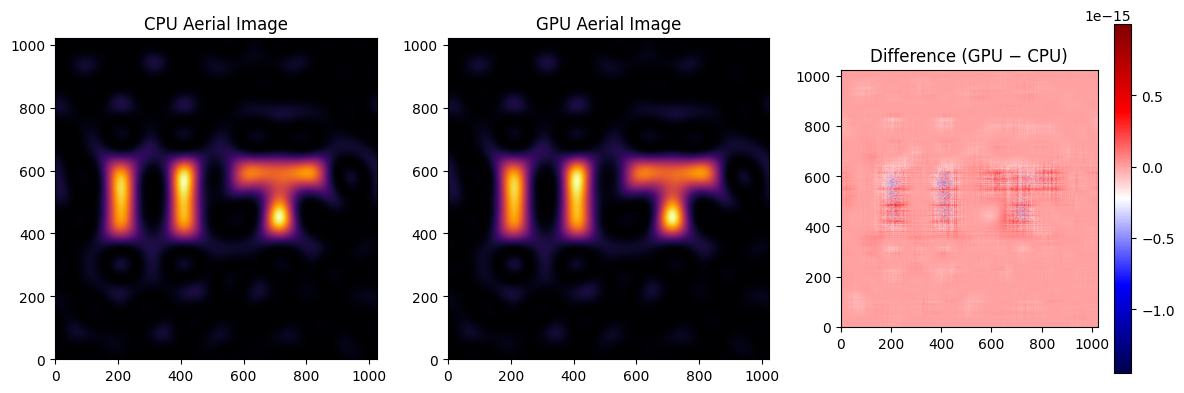

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(I_cpu, cmap="inferno", origin ='lower')
plt.title("CPU Aerial Image")

plt.subplot(1,3,2)
plt.imshow(I_gpu_cpu, cmap="inferno", origin ='lower')
plt.title("GPU Aerial Image")

plt.subplot(1,3,3)
plt.imshow(I_gpu_cpu - I_cpu, cmap="seismic", origin ='lower')
plt.title("Difference (GPU − CPU)")
plt.colorbar()

plt.tight_layout()
plt.show()

In [49]:
import time

# ------------------------------
# CPU Forward Model Timing
# ------------------------------

mask_cpu = mask_cpu_ref.copy()

# warmup (avoid first-call FFT overhead)
_ = np.fft.ifft2(np.fft.fft2(mask_cpu) * pupil)

n_runs = 10
start = time.perf_counter()

for _ in range(n_runs):
    field_cpu = np.fft.ifft2(np.fft.fft2(mask_cpu) * pupil)
    I_cpu = np.abs(field_cpu)**2
    I_cpu /= I_cpu.max()

end = time.perf_counter()

cpu_time = (end - start) / n_runs

print(f"CPU Forward Model Avg Time over {n_runs} runs: {cpu_time:.6f} seconds")

CPU Forward Model Avg Time over 10 runs: 0.101751 seconds


In [50]:
# ------------------------------
# GPU Forward Model Timing
# ------------------------------

mask_gpu = cp.asarray(mask_cpu_ref)
pupil_gpu = cp.asarray(pupil)

# warmup (important)
_ = cifft2(cfft2(mask_gpu) * pupil_gpu)
cp.cuda.Stream.null.synchronize()

n_runs = 10
start = time.perf_counter()

for _ in range(n_runs):
    field_gpu = cifft2(cfft2(mask_gpu) * pupil_gpu)
    I_gpu = cp.abs(field_gpu)**2
    I_gpu /= cp.max(I_gpu)

cp.cuda.Stream.null.synchronize()
end = time.perf_counter()

gpu_time = (end - start) / n_runs

print(f"GPU Forward Model Avg Time over {n_runs} runs: {gpu_time:.6f} seconds")

GPU Forward Model Avg Time over 10 runs: 0.011168 seconds


In [51]:
speedup = cpu_time / gpu_time

print(f"CPU Time : {cpu_time:.6f} sec")
print(f"GPU Time : {gpu_time:.6f} sec")
print(f"Speedup  : {speedup:.2f} ×")


CPU Time : 0.101751 sec
GPU Time : 0.011168 sec
Speedup  : 9.11 ×


In [52]:
np.save("mask_step1.npy", mask_step1)
np.save("z_target.npy", z_target)
np.save("pupil.npy", pupil)
np.save("mask_init.npy", mask)

h_cpu_final = h.copy()
mask_cpu_final = h_to_mask(h_cpu_final)

np.save("mask_final_cpu.npy", mask_cpu_final)

print("CPU final mask saved.")

CPU final mask saved.
